<a href="https://colab.research.google.com/github/sonjoy2074/CSE4531-Project/blob/main/Federated_Learning/client_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train=True):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Testing/"), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, len(test_data)


In [ ]:
dataset_path = "/content/drive/MyDrive/Sonjoy_dataset/User2_Brain_Mri_Images"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
test_loader, test_data_len = get_data_loaders(dataset_path, 32, train=False)

classes = get_classes("/content/drive/MyDrive/Sonjoy_dataset/User2_Brain_Mri_Images/Training")
print(classes, len(classes))


['glioma', 'meningioma', 'notumor', 'pituitary'] 4


In [ ]:
dataloaders = {
    "train": train_loader
}

dataset_sizes = {
    "train": train_data_len
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier for ViT model
n_inputs = model.classifier.in_features  # Accessing the in_features of the last layer in classifier
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)


model = model.to(device)
print(model.classifier)


Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

# Optimizer
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)

            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs
    }

    return model, history

#model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


In [ ]:
model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

Epoch 0/19
----------


100%|██████████| 32/32 [10:37<00:00, 19.91s/it]


train Loss: 0.8003 Acc: 0.7601
Epoch 1/19
----------


100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


train Loss: 0.6058 Acc: 0.8807
Epoch 2/19
----------


100%|██████████| 32/32 [00:51<00:00,  1.62s/it]


train Loss: 0.5604 Acc: 0.9030
Epoch 3/19
----------


100%|██████████| 32/32 [00:51<00:00,  1.62s/it]


train Loss: 0.5444 Acc: 0.9142
Epoch 4/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.65s/it]


train Loss: 0.5215 Acc: 0.9268
Epoch 5/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.5066 Acc: 0.9333
Epoch 6/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.5085 Acc: 0.9330
Epoch 7/19
----------


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


train Loss: 0.5009 Acc: 0.9397
Epoch 8/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.64s/it]


train Loss: 0.4890 Acc: 0.9447
Epoch 9/19
----------


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


train Loss: 0.4878 Acc: 0.9479
Epoch 10/19
----------


100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


train Loss: 0.4728 Acc: 0.9558
Epoch 11/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.65s/it]


train Loss: 0.4695 Acc: 0.9568
Epoch 12/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.64s/it]


train Loss: 0.4637 Acc: 0.9588
Epoch 13/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.4638 Acc: 0.9611
Epoch 14/19
----------


100%|██████████| 32/32 [00:51<00:00,  1.62s/it]


train Loss: 0.4586 Acc: 0.9625
Epoch 15/19
----------


100%|██████████| 32/32 [00:51<00:00,  1.62s/it]


train Loss: 0.4666 Acc: 0.9601
Epoch 16/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.4489 Acc: 0.9722
Epoch 17/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.4392 Acc: 0.9749
Epoch 18/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.4379 Acc: 0.9759
Epoch 19/19
----------


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


train Loss: 0.4410 Acc: 0.9730
Best val Acc: 0.975936


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Save the model
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': exp_lr_scheduler.state_dict(),
    'history': history,
    'classes': classes
}, '/content/drive/MyDrive/Models/doctor_2.pth')


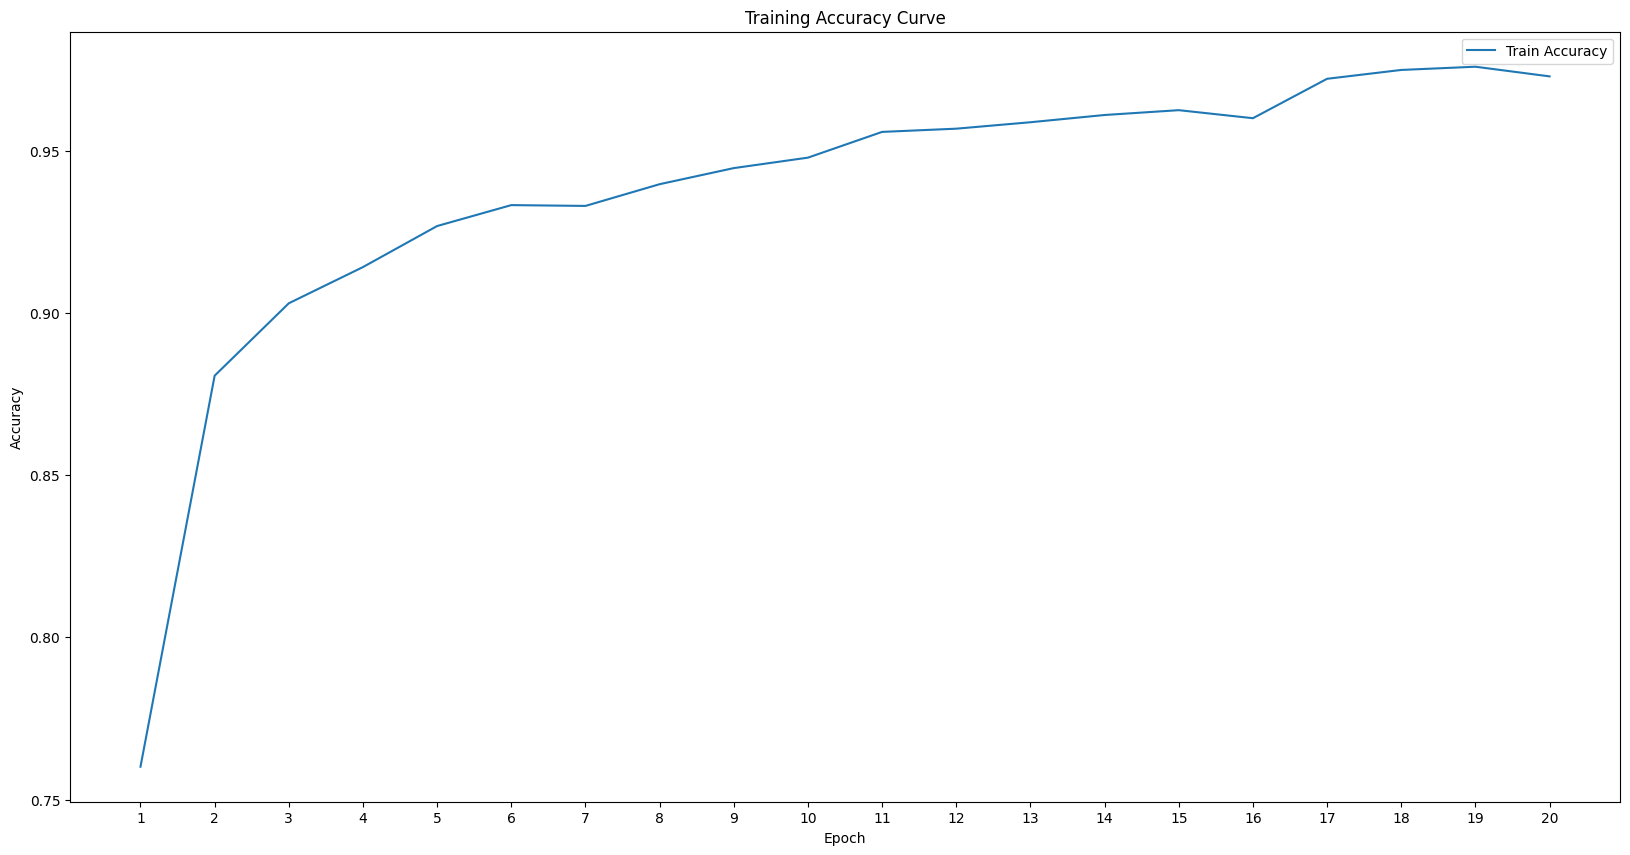

In [ ]:
num_epochs = 20
# Plotting the training accuracy
plt.figure(figsize=(20, 10))
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in history['train_acc']], label='Train Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()


#Test Local Model

In [ ]:
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output.logits, target)  # Use logits to compute the loss
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output.logits, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
    100 * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))


100%|██████████| 32/32 [03:22<00:00,  6.32s/it]

Test Loss: 0.4765
Test Accuracy of glioma: 93% (231/248)
Test Accuracy of meningioma: 92% (229/247)
Test Accuracy of notumor: 97% (242/248)
Test Accuracy of pituitary: 95% (239/249)
Test Accuracy of 94% (941/992)


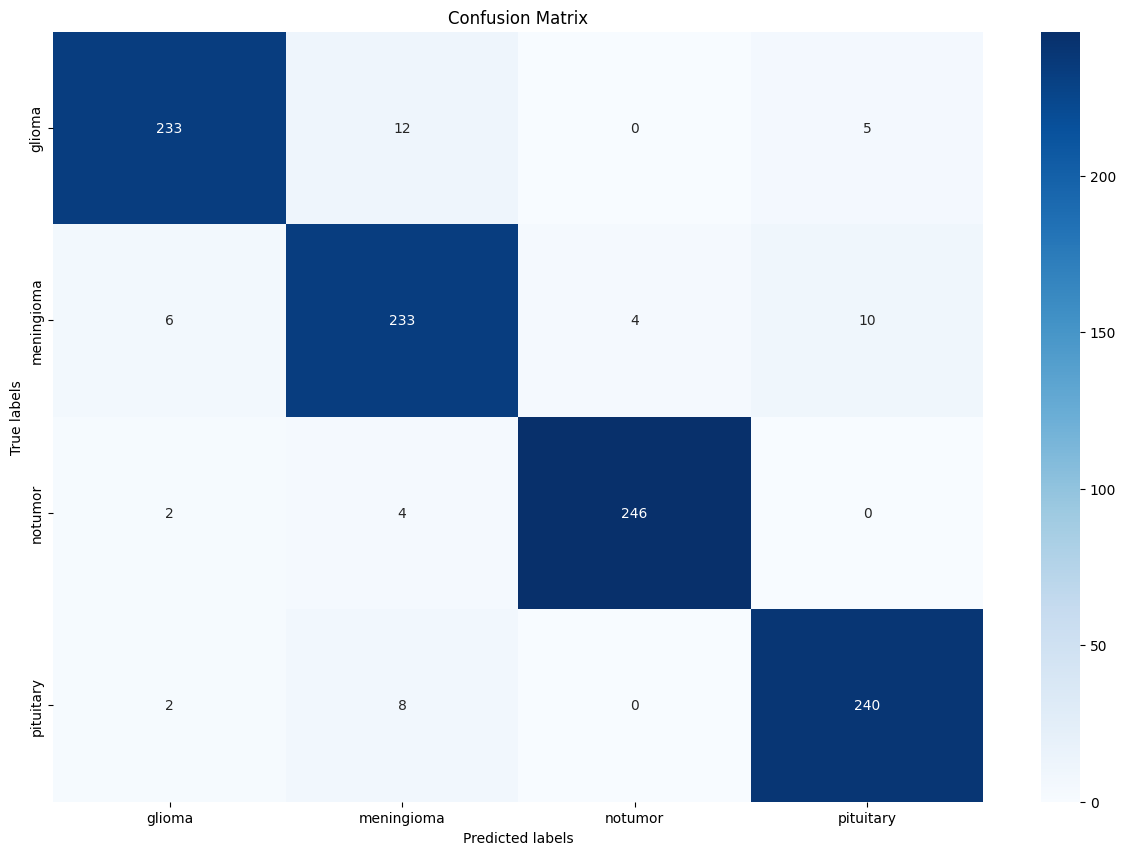

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.93      0.95       250
  meningioma       0.91      0.92      0.91       253
     notumor       0.98      0.98      0.98       252
   pituitary       0.94      0.96      0.95       250

    accuracy                           0.95      1005
   macro avg       0.95      0.95      0.95      1005
weighted avg       0.95      0.95      0.95      1005

Class: glioma
  Precision: 0.9588
  Recall:    0.9320
  F1 Score:  0.9452
--------------------
Class: meningioma
  Precision: 0.9066
  Recall:    0.9209
  F1 Score:  0.9137
--------------------
Class: notumor
  Precision: 0.9840
  Recall:    0.9762
  F1 Score:  0.9801
--------------------
Class: pituitary
  Precision: 0.9412
  Recall:    0.9600
  F1 Score:  0.9505
--------------------
Overall Metrics:
  Overall Precision: 0.9476
  Overall Recall:    0.9473
  Overall F1 Score:  0.9473


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)  # Extract logits and apply torch.max()

    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_names = classes  # Your list of class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")
    print("-" * 20)

# Compute overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Overall Metrics:")
print(f"  Overall Precision: {overall_precision:.4f}")
print(f"  Overall Recall:    {overall_recall:.4f}")
print(f"  Overall F1 Score:  {overall_f1:.4f}")
